In [15]:
import pandas as pd 
import matplotlib.pyplot as plt
from mplsoccer import Pitch, add_image, FontManager
import requests
import json
from bs4 import BeautifulSoup
from PIL import Image 
from io import BytesIO
from urllib.request import urlopen
from urllib.error import HTTPError
import ScraperFC as sfc
import os

sofascore = sfc.Sofascore()


URL_MATCH = "https://www.sofascore.com/boca-juniors-fluminense/lOscob#id:11716722"
URL_MATCH = URL_MATCH.replace("id:", "")

URL_MATCH


'https://www.sofascore.com/boca-juniors-fluminense/lOscob#11716722'

### Generar el grafico de ejemplo

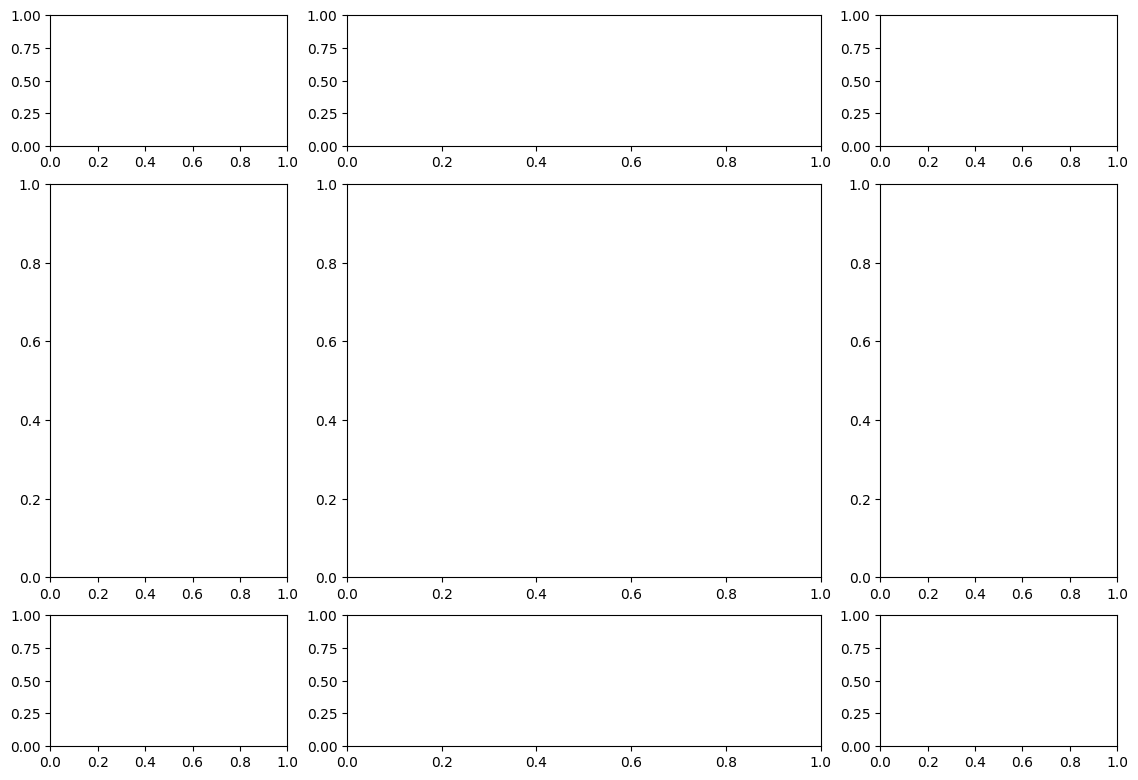

In [16]:
fig = plt.figure(figsize=(16,9),constrained_layout=True)
gs = fig.add_gridspec(nrows=6,ncols=6)
fig.set_facecolor('white')

# escudo local
ax1 = fig.add_subplot(gs[0,0:1])

# escudo visitante
ax2 = fig.add_subplot(gs[0,3:4])

ax3 = fig.add_subplot(gs[0,1:3])

# equipo local
ax6 = fig.add_subplot(gs[1:4,:1])

ax10 = fig.add_subplot(gs[4:5,:1])

# info partido
ax7 = fig.add_subplot(gs[1:4,1:3])

ax8 = fig.add_subplot(gs[4:5,1:3])

# equipo visitante
ax9 = fig.add_subplot(gs[1:4,3:4])

ax11 = fig.add_subplot(gs[4:5,3:4])

# info desarrollo
#ax8 = fig.add_subplot(gs[5:,:4])



### Agregar la fuente

In [17]:
fuente1 = FontManager("https://github.com/google/fonts/blob/main/ofl/abeezee/ABeeZee-Regular.ttf?raw=true")

### Obtener informacion del partido

In [18]:
partido_sofascore = sofascore.get_match_data(URL_MATCH)
estadisticas_partido = sofascore.get_general_match_stats(URL_MATCH)
df_local, df_visit = sofascore.get_players_match_stats(URL_MATCH)


### Obtener jugadores destacados

In [19]:
info_jugador_destacado_local = df_local[['name', 'shortName', 'rating']].sort_values(by='rating', ascending=False).iloc[0]
info_jugador_destacado_visit = df_visit[['name','shortName', 'rating']].sort_values(by='rating', ascending=False).iloc[0]

jugador_destacado_local = info_jugador_destacado_local['name']
jugador_destacado_visit = info_jugador_destacado_visit['name']

jugador_destacado_local_shortName = info_jugador_destacado_local['shortName']
jugador_destacado_visit_shortName = info_jugador_destacado_visit['shortName']


### Obtener imagen del jugador destacado de cada equipo

In [20]:

id_jug_local = df_local[df_local['name'] == jugador_destacado_local].id.values[0]
id_jug_visit = df_visit[df_visit['name'] == jugador_destacado_visit].id.values[0]

try:
  imagen_jug_local = Image.open(urlopen(f'https://api.sofascore.app/api/v1/player/{id_jug_local}/image'))
except HTTPError as e:
  print(f'An exception occurred {e} con jugador local')
  imagen_jug_local = Image.open('static/img/player.png')

try:
  imagen_jug_visit = Image.open(urlopen(f'https://api.sofascore.app/api/v1/player/{id_jug_visit}/image'))
except HTTPError as e:
  print(f'An exception occurred {e} con jugador visitante')
  imagen_jug_visit = Image.open('static/img/player.png')


### Obtener mapa de calor de los jugadores destacados

In [21]:
name_jug_local = df_local[df_local['name'] == jugador_destacado_local].name.values[0]
name_jug_visit = df_visit[df_visit['name'] == jugador_destacado_visit].name.values[0]

heatmap_jug_local = sofascore.get_player_heatmap(URL_MATCH, name_jug_local)
heatmap_jug_visit = sofascore.get_player_heatmap(URL_MATCH, name_jug_visit)

### Sacar inforamcion de cada jugador

In [22]:
df_jug_local = df_local[df_local['name'] == jugador_destacado_local]
df_jug_visit = df_visit[df_visit['name'] == jugador_destacado_visit]

# pasar los valores nulos a 0
df_jug_local = df_jug_local.fillna(0)
df_jug_visit = df_jug_visit.fillna(0)

pos_local = df_jug_local["position"].iloc[0][0]
pos_visit = df_jug_visit["position"].iloc[0][0]

if pos_local == "G":
    pos_local = "arquero"
elif pos_local == "D":
    pos_local = "defensa"
elif pos_local == "M":
    pos_local = "mediocampista"
elif pos_local == "F":
    pos_local = "delantero"
    
if pos_visit == "G":
    pos_visit = "arquero"
elif pos_visit == "D":
    pos_visit = "defensa"
elif pos_visit == "M":
    pos_visit = "mediocampista"
elif pos_visit == "F":
    pos_visit = "delantero"

f'{pos_local} - {pos_visit}'

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2628\548057219.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_jug_local = df_jug_local.fillna(0)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2628\548057219.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_jug_visit = df_jug_visit.fillna(0)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2628\548057219.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

'mediocampista - mediocampista'

### obtener informacion de los equipos

In [23]:
# id equipos
idlocal = partido_sofascore['homeTeam']['id']
idvisit = partido_sofascore['awayTeam']['id']

# escudos de los equipos
imagen1 = Image.open(urlopen(f'https://api.sofascore.app/api/v1/team/{idlocal}/image'))
imagen2 = Image.open(urlopen(f'https://api.sofascore.app/api/v1/team/{idvisit}/image'))

# goles de los equipos
goleslocal = partido_sofascore['homeScore']['normaltime']
golesvisit = partido_sofascore['awayScore']['normaltime']


### Obtener match momentum del partido

In [24]:
try:
    match_momentum = sofascore.match_momentum(URL_MATCH)

    match_momentum_local = match_momentum[match_momentum['value'] > 0]
    match_momentum_visit = match_momentum[match_momentum['value'] < 0]
except KeyError:
    match_momentum = None
    


### Obtener info de la jornada

In [25]:
torneo = partido_sofascore['season']['name']
fecha = partido_sofascore['roundInfo']['round']

nombre_local = partido_sofascore['homeTeam']['shortName']
nombre_visit = partido_sofascore['awayTeam']['shortName']

# si alguno de los colores del colar pasas el umbral de blanco (200 en rgb) busca el color secundario
color_local = partido_sofascore['homeTeam']['teamColors']['primary']
color_local = partido_sofascore['homeTeam']['teamColors']['secondary'] if all(int(color_local[i:i+2], 16) > 200 for i in (1, 3, 5)) else color_local

color_visit = partido_sofascore['awayTeam']['teamColors']['primary']
color_visit = partido_sofascore['awayTeam']['teamColors']['secondary'] if all(int(color_visit[i:i+2], 16) > 200 for i in (1, 3, 5)) else color_visit


f'{nombre_local} teamColor: {color_local} - {nombre_visit} teamColor: {color_visit}'


'Boca Juniors teamColor: #003399 - Fluminense teamColor: #660000'

### Quitar las lineas de los plots

In [26]:
def sacar_spines(ax):
    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

### Obtener estadísticas de cada equipo por separado

In [27]:
listas_estadisticas_partido = ['Expected goals', 'Ball possession', 'Total shots', 'Shots on target', 'Corner kicks', 'Fouls', 'Yellow cards', 'Red cards', 'Counter attacks', 'Goalkeeper saves']
# si no tiene xG lo quita
listas_estadisticas_partido = [elemento for elemento in listas_estadisticas_partido if elemento != 'Expected goals' or 'Expected goals' in estadisticas_partido['name'].to_list()]
lista_valores_partido_local = []
lista_valores_partido_visit = []

# equipo local
for estadistica in listas_estadisticas_partido:
    if estadistica in estadisticas_partido['name'].values:
        valor = estadisticas_partido[estadisticas_partido['name'] == estadistica]['home'].values[0]
        lista_valores_partido_local.append(valor)
    else:
        lista_valores_partido_local.append(0)
    
for estadistica in listas_estadisticas_partido:
    if estadistica in estadisticas_partido['name'].values:
        valor = estadisticas_partido[estadisticas_partido['name'] == estadistica]['away'].values[0]
        lista_valores_partido_visit.append(valor)
    else:
        lista_valores_partido_visit.append(0) 


### Agregar la informacion al plot

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2628\1327485534.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax6.text(0.1,.8, f'{int(df_jug_local["rating"])} Nota Sofascore', ha='left', va='center', size=15, color=color_local)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2628\1327485534.py:43: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  f'{int(df_jug_local["accuratePass"])}/{int(df_jug_local["totalPass"])} ({int(df_jug_local["accuratePass"]/df_jug_local["totalPass"]*100)}%) Pases Comp.',
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2628\1327485534.py:47: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax6.text(0.1, .6, f'{int(goals)} {"Gol" if int(goals) == 1 else "Goles"}', ha='left', va='center',

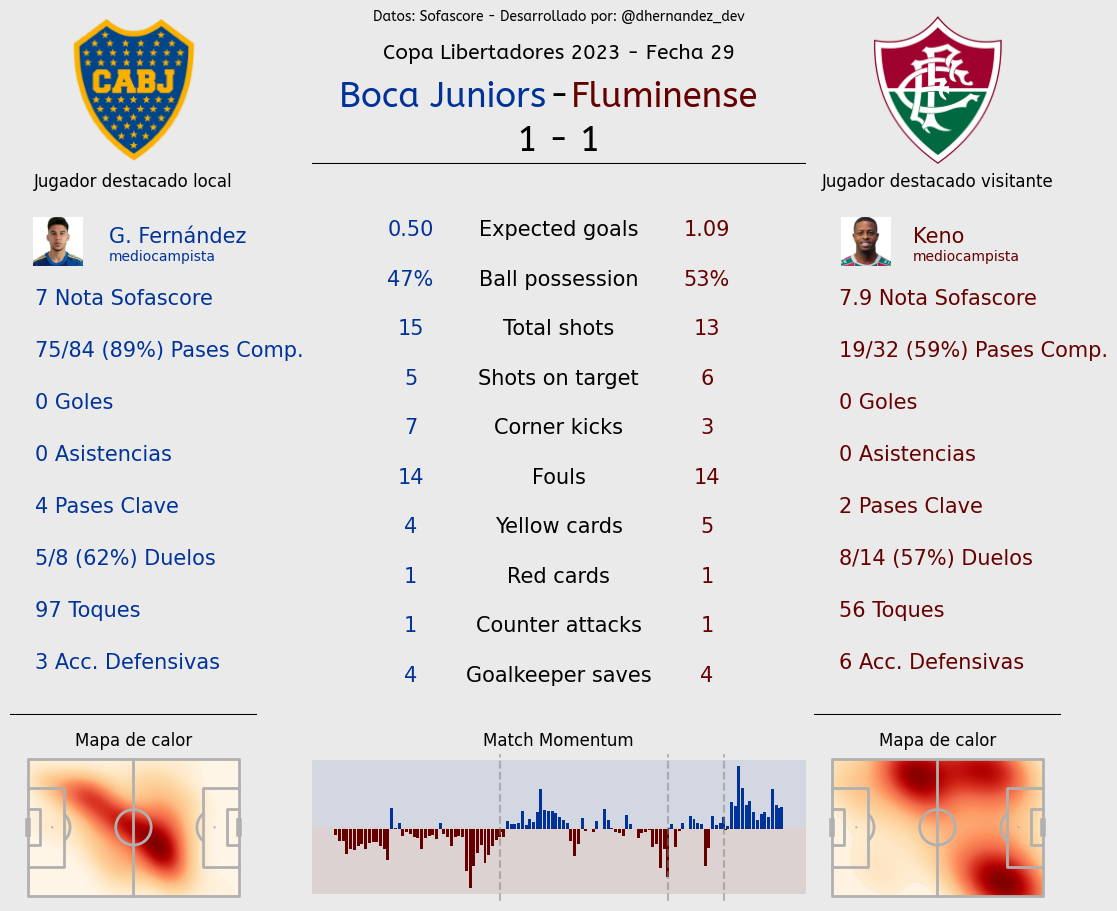

In [28]:
file_url = f'partidos/{torneo}/'.replace(" ", "_")
file_name = f'{nombre_local}_{nombre_visit}_fecha_{fecha}'.replace(" ", "_")
color = '#EAEAEA'

fig = plt.figure(figsize=(16,9),constrained_layout=True)
gs = fig.add_gridspec(nrows=5,ncols=6)
fig.set_facecolor(color)

# Escudo local
ax1 = fig.add_subplot(gs[0,0:1])
ax1.imshow(imagen1)
sacar_spines(ax1)
ax1.set_facecolor(color)

# Escudo visitante
ax2 = fig.add_subplot(gs[0,3:4])
ax2.imshow(imagen2)
sacar_spines(ax2)
ax2.set_facecolor(color)

# info del partido
ax3 = fig.add_subplot(gs[0, 1:3])
ax3.text(.5, 1, f'Datos: Sofascore - Desarrollado por: @dhernandez_dev', ha='center', va='center', fontproperties=fuente1.prop)
ax3.text(.5, .75, f'{torneo} - Fecha {fecha}', ha='center', va='center', fontproperties=fuente1.prop, size=15)
ax3.text(.475, .45, f'{nombre_local}', ha='right', va='center', fontproperties=fuente1.prop, size=25, color=color_local)
ax3.text(.525, .45, f'{nombre_visit}', ha='left', va='center', fontproperties=fuente1.prop, size=25, color=color_visit)
ax3.text(.5, .45, f'-', ha='center', va='center', fontproperties=fuente1.prop, size=25)
ax3.text(.5, .15, f'{goleslocal} - {golesvisit}', ha='center', va='center', fontproperties=fuente1.prop, size=25)
ax3.axhline(0, color='black')
sacar_spines(ax3)
ax3.set_facecolor(color)

# Jugador Destacado local
ax6 = fig.add_subplot(gs[1:4, :1])
ax6.set_title('Jugador destacado local')
ax_image2 = add_image(imagen_jug_local, fig, left=0.005, bottom=0.71, width=0.055, height=0.055) if imagen_jug_local else None
ax6.text(.4,.92, f'{jugador_destacado_local_shortName}', ha='left', va='center', size=15, color=color_local)
ax6.text(.4,.88, f'{pos_local}', ha='left', va='center', size=10, color=color_local)
#
ax6.text(0.1,.8, f'{int(df_jug_local["rating"])} Nota Sofascore', ha='left', va='center', size=15, color=color_local)
#
ax6.text(0.1,.7, 
         f'{int(df_jug_local["accuratePass"])}/{int(df_jug_local["totalPass"])} ({int(df_jug_local["accuratePass"]/df_jug_local["totalPass"]*100)}%) Pases Comp.', 
         ha='left', va='center', size=15, color=color_local)
#
goals = df_jug_local["goals"] if 'goals' in df_jug_local.columns else 0
ax6.text(0.1, .6, f'{int(goals)} {"Gol" if int(goals) == 1 else "Goles"}', ha='left', va='center', size=15, color=color_local) # todo
#
goalsAssist = df_jug_local["goalsAssist"] if 'goalsAssist' in df_jug_local.columns else 0
ax6.text(0.1,.5, f'{int(goalsAssist)} {"Asistencia" if int(goalsAssist) == 1 else "Asistencias"}', ha='left', va='center', size=15, color=color_local)
#
keyPass = df_jug_local["keyPass"] if 'keyPass' in  df_jug_local.columns else 0
ax6.text(0.1,.4, f'{int(keyPass)} {"Pase Clave" if int(keyPass == 1) else "Pases Clave"}', ha='left', va='center', size=15, color=color_local)
#
duel_percen = int(df_jug_local["duelWon"]/(df_jug_local["duelLost"]+df_jug_local["duelWon"])*100) if int(df_jug_local["duelWon"]) > 0 else 0
ax6.text(0.1,.3,
         f'{int(df_jug_local["duelWon"])}/{int(df_jug_local["duelLost"])+int(df_jug_local["duelWon"])} ({duel_percen}%) Duelos', 
         ha='left', va='center', size=15, color=color_local)  
#
ax6.text(0.1, .2, f'{int(df_jug_local["touches"])} Toques', ha='left', va='center', size=15, color=color_local) 
#
ax6.text(0.1, .1, f'{int(df_jug_local["totalTackle"]+df_jug_local["interceptionWon"]+df_jug_local["totalClearance"])} Acc. Defensivas', ha='left', va='center', size=15, color=color_local) 
ax6.axhline(0, color='black')
sacar_spines(ax6)
ax6.set_facecolor(color)

# heatmap jugador local
ax10 = fig.add_subplot(gs[4:, :1])
ax10.set_title('Mapa de calor')
cmap = 'hot'
pitch = Pitch(pitch_type='opta')
pitch.draw(ax=ax10)
pitch.kdeplot(heatmap_jug_local.x, heatmap_jug_local.y, ax=ax10,
              levels=100,
              shade=True,
              zorder=-1,
              shade_lowest=True,
              cmap='OrRd')

plt.gca().invert_xaxis
sacar_spines(ax10)
ax10.set_facecolor(color)

# estadisticas del partido
ax7 = fig.add_subplot(gs[1:, 1:3])
i = 1.05
for n in range(len(listas_estadisticas_partido)):
    ax7.text(.5, i-.1, listas_estadisticas_partido[n], ha='center', va='center', size=15)
    i-=.07
i = 1.05
for n in range(len(lista_valores_partido_local)):
    ax7.text(.2, i-.1, lista_valores_partido_local[n], ha='center', va='center', size=15, color = color_local)
    i-=.07
i = 1.05
for n in range(len(lista_valores_partido_visit)):
    ax7.text(.8, i-.1, lista_valores_partido_visit[n], ha='center', va='center', size=15, color = color_visit)
    i-=.07
sacar_spines(ax7)
ax7.set_facecolor(color)

# match momentum
if match_momentum is not None and not match_momentum_local.empty and not match_momentum_visit.empty:
    ax11 = fig.add_subplot(gs[4:,1:3])
    ax11.set_title('Match Momentum')
    ax11.bar(match_momentum_local.minute, match_momentum_local.value, color=color_local)
    ax11.bar(match_momentum_visit.minute, match_momentum_visit.value, color=color_visit)
    # Obtener el límite inferior y superior del eje y
    y_bottom, y_top = ax11.get_ylim()
    # Calcular la mitad del rango vertical
    y_mid = 0.5 * (y_bottom + y_top)
    # Agregar regiones de color a la mitad superior e inferior del eje y
    ax11.axhspan(y_mid, y_top, facecolor=color_local, alpha=0.1)  # Color para la mitad superior
    ax11.axhspan(y_bottom, y_mid, facecolor=color_visit, alpha=0.1)  # Color para la mitad inferior
    ax11.axvline(x=45, color='gray', linestyle='--', alpha=0.5) # linea medio tiempo
    if match_momentum_local.minute.iloc[-1] > 105:
        ax11.axvline(x=90, color='gray', linestyle='--', alpha=0.5) # linea 90 minutos
        ax11.axvline(x=105, color='gray', linestyle='--', alpha=0.5) # linea de mitad de prorroga
    sacar_spines(ax11)
    ax11.set_facecolor(color)


# Jugador Destacado visitante
ax8 = fig.add_subplot(gs[1:4, 3:4])
ax8.set_title('Jugador destacado visitante')
ax_image3 = add_image(imagen_jug_visit, fig, left=0.51, bottom=0.71, width=0.055, height=0.055) if imagen_jug_visit else None
ax8.text(.4,.92, f'{jugador_destacado_visit_shortName}', ha='left', va='center', size=15, color=color_visit)
ax8.text(.4,.88, f'{pos_visit}', ha='left', va='center', size=10, color=color_visit)
#
ax8.text(0.1,.8, f'{float(df_jug_visit["rating"])} Nota Sofascore', ha='left', va='center', size=15, color=color_visit)
#
ax8.text(0.1,.7, 
         f'{int(df_jug_visit["accuratePass"])}/{int(df_jug_visit["totalPass"])} ({int(df_jug_visit["accuratePass"]/df_jug_visit["totalPass"]*100)}%) Pases Comp.', 
         ha='left', va='center', size=15, color=color_visit)
#
goals = df_jug_visit["goals"] if 'goals' in df_jug_visit.columns else 0
ax8.text(0.1, .6, f'{int(goals)} {"Gol" if int(goals) == 1 else "Goles"}', ha='left', va='center', size=15, color=color_visit)
#
goalsAssist = df_jug_visit["goalsAssist"] if 'goalsAssist' in df_jug_visit.columns else 0
ax8.text(0.1,.5, f'{int(goalsAssist)} {"Asistencia" if int(goalsAssist) == 1 else "Asistencias"}', ha='left', va='center', size=15, color=color_visit)
#
keyPass = df_jug_visit["keyPass"] if 'keyPass' in  df_jug_visit.columns else 0
ax8.text(0.1,.4, f'{int(keyPass)} {"Pase Clave" if int(keyPass == 1) else "Pases Clave"}', ha='left', va='center', size=15, color=color_visit)
#
duel_percen = int(df_jug_visit["duelWon"]/(df_jug_visit["duelLost"]+df_jug_visit["duelWon"])*100) if int(df_jug_visit["duelWon"]) > 0 else 0
ax8.text(0.1,.3,
         f'{int(df_jug_visit["duelWon"])}/{int(df_jug_visit["duelLost"])+int(df_jug_visit["duelWon"])} ({duel_percen}%) Duelos', 
         ha='left', va='center', size=15, color=color_visit)  
#
ax8.text(0.1, .2, f'{int(df_jug_visit["touches"])} Toques', ha='left', va='center', size=15, color=color_visit) 
#
ax8.text(0.1, .1, f'{int(df_jug_visit["totalTackle"]+df_jug_visit["interceptionWon"]+df_jug_visit["totalClearance"])} Acc. Defensivas', ha='left', va='center', size=15, color=color_visit) 

ax8.axhline(0, color='black')
sacar_spines(ax8)
ax8.set_facecolor(color)

# heatmap jugador visitante
ax9 = fig.add_subplot(gs[4:, 3:4])
ax9.set_title('Mapa de calor')
cmap = 'hot'
pitch = Pitch(pitch_type='opta')
pitch.draw(ax=ax9)
pitch.kdeplot(heatmap_jug_visit.x, heatmap_jug_visit.y, ax=ax9,
              levels=100,
              shade=True,
              zorder=-1,
              shade_lowest=True,
              cmap='OrRd')

plt.gca().invert_xaxis
sacar_spines(ax9)
ax9.set_facecolor(color)

# Guardar la figura en una imagen con la misma resolución que se ve en el plot en consola
if not os.path.exists(file_url):
    os.makedirs(file_url)
fig.savefig(f'{file_url}{file_name}.png',  bbox_inches='tight')  # Ajusta dpi según sea necesario
